Shape: (118858, 17)
Columns: ['daynight_N', 'lat', 'lon', 'fire_weather_index', 'pressure_mean', 'wind_direction_mean', 'wind_direction_std', 'solar_radiation_mean', 'dewpoint_mean', 'cloud_cover_mean', 'evapotranspiration_total', 'humidity_min', 'temp_mean', 'temp_range', 'wind_speed_max', 'occured', 'frp']

=== Classification: Fire Occurrence (occured) ===
Accuracy: 0.5873716977957261
              precision    recall  f1-score   support

           0       0.58      0.61      0.60     11881
           1       0.59      0.56      0.58     11891

    accuracy                           0.59     23772
   macro avg       0.59      0.59      0.59     23772
weighted avg       0.59      0.59      0.59     23772



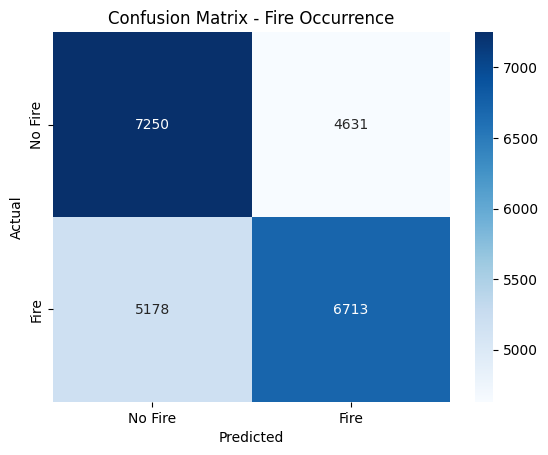

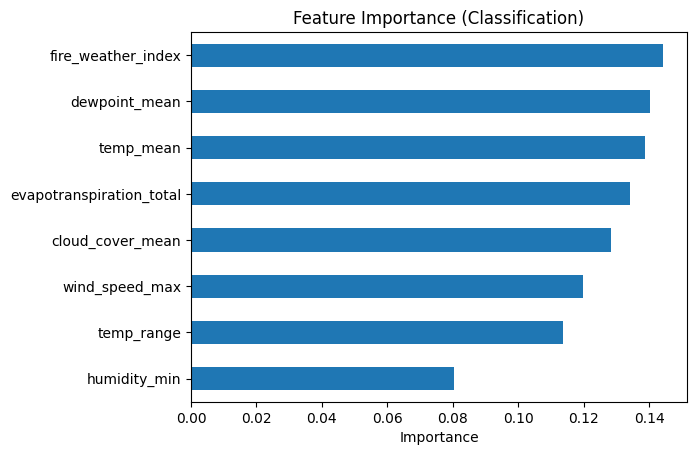


=== Regression: Fire Intensity (FRP) ===
RMSE: 31.739757311820696
R² Score: 0.04972286591753039


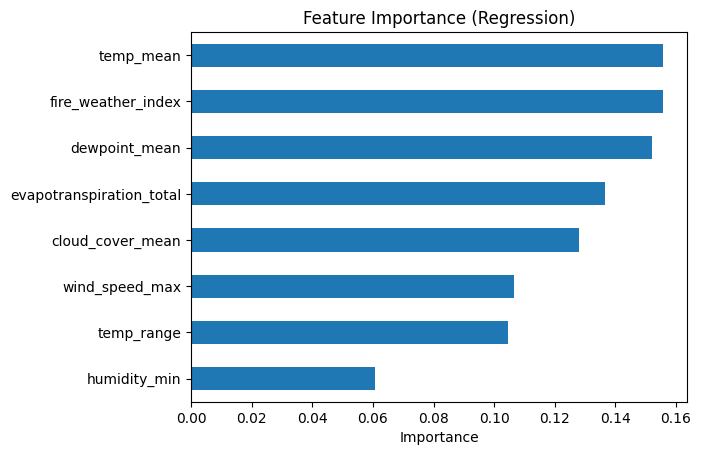


Models & scaler saved in ./models/


In [6]:
# ============================================================
# Wildfire Smoke Spread Prediction (Classification + Regression)
# CSV columns matched to: daynight_N, lat, lon, fire_weather_index,
# pressure_mean, wind_direction_mean, wind_direction_std, solar_radiation_mean,
# dewpoint_mean, cloud_cover_mean, evapotranspiration_total, humidity_min,
# temp_mean, temp_range, wind_speed_max, occured, frp
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, r2_score
)

# ---------- Load ----------
df = pd.read_csv("data/final_dataset.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# ---------- Select features ----------
# Focused set that best explains fire/smoke behaviour
FEATURES = [
    'fire_weather_index',
    'humidity_min',
    'temp_mean',
    'temp_range',
    'wind_speed_max',
    'dewpoint_mean',
    'cloud_cover_mean',
    'evapotranspiration_total'
]

TARGET_CLS = 'occured'   # 0/1 fire occurrence
TARGET_REG = 'frp'       # fire radiative power (intensity)

# sanity check: ensure required columns exist
missing = [c for c in FEATURES + [TARGET_CLS, TARGET_REG] if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns in CSV: {missing}")

# keep only needed columns & drop rows with any NA in them
df_model = df[FEATURES + [TARGET_CLS, TARGET_REG]].dropna().copy()

# ensure numeric dtypes
for c in FEATURES + [TARGET_CLS, TARGET_REG]:
    df_model[c] = pd.to_numeric(df_model[c], errors='coerce')
df_model = df_model.dropna()

# targets
y_cls = df_model[TARGET_CLS].astype(int)
y_reg = df_model[TARGET_REG].astype(float)

# features
X = df_model[FEATURES]

# ---------- Split (same split for both tasks) ----------
# Try stratified split for balanced classification; fall back if not possible
try:
    X_train, X_test, y_cls_train, y_cls_test, y_reg_train, y_reg_test = train_test_split(
        X, y_cls, y_reg, test_size=0.2, random_state=42, stratify=y_cls
    )
except ValueError:
    X_train, X_test, y_cls_train, y_cls_test, y_reg_train, y_reg_test = train_test_split(
        X, y_cls, y_reg, test_size=0.2, random_state=42
    )

# ---------- Scale ----------
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# ---------- Classification: predict 'occured' ----------
cls_model = RandomForestClassifier(n_estimators=200, random_state=42)
cls_model.fit(X_train_sc, y_cls_train)

y_cls_pred = cls_model.predict(X_test_sc)

print("\n=== Classification: Fire Occurrence (occured) ===")
print("Accuracy:", accuracy_score(y_cls_test, y_cls_pred))
print(classification_report(y_cls_test, y_cls_pred))

cm = confusion_matrix(y_cls_test, y_cls_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Fire','Fire'], yticklabels=['No Fire','Fire'])
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Confusion Matrix - Fire Occurrence")
plt.show()

# Feature importance (classification)
imp_cls = pd.Series(cls_model.feature_importances_, index=FEATURES).sort_values(ascending=False)
imp_cls.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Feature Importance (Classification)")
plt.xlabel("Importance")
plt.show()

# ---------- Regression: predict 'frp' ----------
reg_model = RandomForestRegressor(n_estimators=200, random_state=42)
reg_model.fit(X_train_sc, y_reg_train)

y_reg_pred = reg_model.predict(X_test_sc)

mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)  # compatible with all sklearn versions

print("\n=== Regression: Fire Intensity (FRP) ===")
print("RMSE:", rmse)
print("R² Score:", r2_score(y_reg_test, y_reg_pred))

# Feature importance (regression)
imp_reg = pd.Series(reg_model.feature_importances_, index=FEATURES).sort_values(ascending=False)
imp_reg.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Feature Importance (Regression)")
plt.xlabel("Importance")
plt.show()

# ---------- Save artifacts (optional, good for submission) ----------
os.makedirs("models", exist_ok=True)
from joblib import dump
dump(cls_model, "models/occurrence_rf.joblib")
dump(reg_model, "models/frp_rf.joblib")
dump(scaler,   "models/feature_scaler.joblib")
print("\nModels & scaler saved in ./models/")
